In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from livelossplot import PlotLosses

plotlosses = PlotLosses()

import time

import letter_recognition.nn.activation as activation
import letter_recognition.nn.layers as nn
import letter_recognition.nn.loss as loss
from letter_recognition import RNG

%matplotlib inline

In [2]:
# Load data
with open("../data/processed/data.npz", "rb") as f:
    data = np.load(f)
    images = data["X"]
    labels = data["Y"]

In [3]:
# Train/test split
train_percentage = 0.7
split_point = int(len(images) * train_percentage)
x_train, y_train = images[:split_point], labels[:split_point]
x_test, y_test = images[split_point:], labels[split_point:]

In [4]:
# Model parameters
conv1_out_channels = 6
conv1_kernel_size = (5, 5)
maxpool1_size = (2, 2)
conv2_out_channels = 16
conv2_kernel_size = (5, 5)
maxpool2_size = (2, 2)

linear1_in_feat = conv2_out_channels * 4 * 4
linear1_out_feat = 120
linear2_out_feat = 84

lr = 0.01
batch_size = 32
epoch_number = 16

# Model architecture
conv1 = nn.Conv2d(1, conv1_out_channels, conv1_kernel_size)
maxpool1 = nn.MaxPool2d(maxpool1_size)
conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, conv2_kernel_size)
maxpool2 = nn.MaxPool2d(maxpool2_size)
linear1 = nn.Linear(linear1_in_feat, linear1_out_feat)
linear2 = nn.Linear(linear1_out_feat, linear2_out_feat)
linear3 = nn.Linear(linear2_out_feat, 26)

criterion = loss.CrossEntropy()

relu = activation.ReLU()
softmax = activation.Softmax()

In [5]:
# Optional downscaling
scale_factor = 4
x_train = x_train[:len(x_train) // scale_factor]
y_train = y_train[:len(y_train) // scale_factor]
x_test = x_test[:len(x_test) // scale_factor]
y_test = y_test[:len(y_test) // scale_factor]

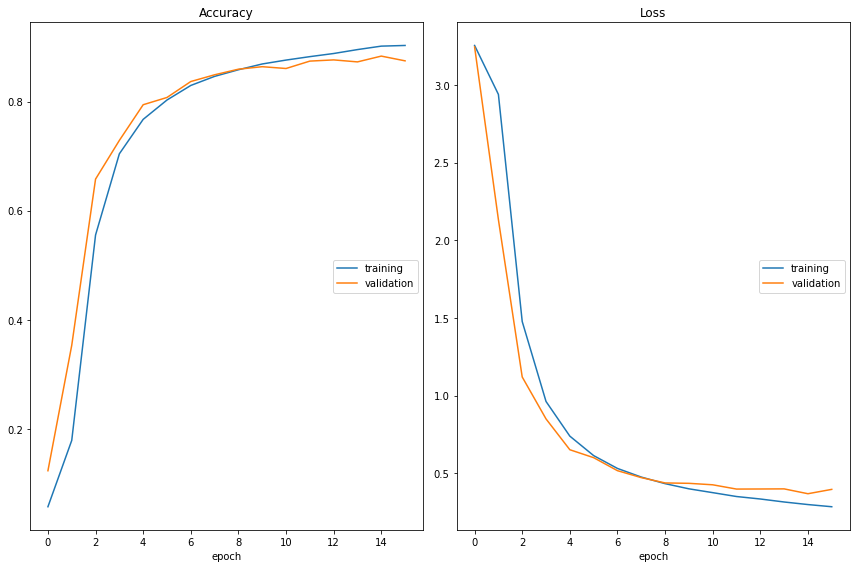

Accuracy
	training         	 (min:    0.057, max:    0.903, cur:    0.903)
	validation       	 (min:    0.123, max:    0.883, cur:    0.875)
Loss
	training         	 (min:    0.284, max:    3.255, cur:    0.284)
	validation       	 (min:    0.368, max:    3.246, cur:    0.396)


In [6]:
epoch_list = []
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
train_loss_sum = 0
test_loss_sum = 0
train_acc_sum = 0
test_acc_sum = 0

for epoch in range(epoch_number):
    # Shuffle
    p = RNG.permutation(len(x_train))
    x_train = x_train[p]
    y_train = y_train[p]

    # Train
    x_train_batches = np.array_split(x_train, len(x_train) // batch_size)
    y_train_batches = np.array_split(y_train, len(y_train) // batch_size)
    
    for i in tqdm(range(len(x_train_batches)), f"Epoch {epoch+1} training"):
        x = x_train_batches[i]
        y = y_train_batches[i]
        
        # Forward pass
        out_conv1 = conv1.forward(x)
        out_conv1_relu = relu.forward(out_conv1)
        out_maxpool1, idx_maxpool1 = maxpool1.forward(out_conv1_relu)
        out_conv2 = conv2.forward(out_maxpool1)
        out_conv2_relu = relu.forward(out_conv2)
        out_maxpool2, idx_maxpool2 = maxpool2.forward(out_conv2_relu)
        
        out_maxpool2_reshaped = out_maxpool2.reshape(out_maxpool2.shape[0], linear1_in_feat)
        out_linear1 = linear1.forward(out_maxpool2_reshaped)
        out_linear1_relu = relu.forward(out_linear1)
        out_linear2 = linear2.forward(out_linear1_relu)
        out_linear2_relu = relu.forward(out_linear2)
        out_linear3 = linear3.forward(out_linear2_relu)
        current_loss = criterion.calculate(out_linear3, y)

        # Gradient calculation
        dx_loss = criterion.backward(out_linear3, y)
        dx_linear3, dw_linear3, db_linear3 = linear3.backward(dx_loss, out_linear2_relu)
        dx_linear2_relu = relu.backward(dx_linear3, out_linear2)     
        dx_linear2, dw_linear2, db_linear2 = linear2.backward(dx_linear2_relu, out_linear1_relu)
        dx_linear1_relu = relu.backward(dx_linear2, out_linear1)
        dx_linear1, dw_linear1, db_linear1 = linear1.backward(dx_linear1_relu, out_maxpool2_reshaped)
        dx_linear1 = dx_linear1.reshape(out_maxpool2.shape)
    
        dx_maxpool2 = maxpool2.backward(dx_linear1, out_conv2_relu, idx_maxpool2)
        dx_conv2_relu = relu.backward(dx_maxpool2, out_conv2)
        dx_conv2, dw_conv2, db_conv2 = conv2.backward(dx_conv2_relu, out_maxpool1)
        
        dx_maxpool1 = maxpool1.backward(dx_conv2, out_conv1_relu, idx_maxpool1)
        dx_conv1_relu = relu.backward(dx_maxpool1, out_conv1)
        _, dw_conv1, db_conv1 = conv1.backward(dx_conv1_relu, x)

        # SGD
        conv1.weight -= lr * dw_conv1
        conv1.bias -= lr * db_conv1
        conv2.weight -= lr * dw_conv2
        conv2.bias -= lr * db_conv2
        linear1.weight -= lr * dw_linear1
        linear1.bias -= lr * db_linear1
        linear2.weight -= lr * dw_linear2
        linear2.bias -= lr * db_linear2
        linear3.weight -= lr * dw_linear3
        linear3.bias -= lr * db_linear3

        # Metrics
        train_loss_sum += current_loss
        train_acc_sum += np.sum(y == np.argmax(softmax.forward(out_linear3), axis=1).astype("float")) / x.shape[0]
      
    # Test
    x_test_batches = np.array_split(x_test, len(x_test) // batch_size)
    y_test_batches = np.array_split(y_test, len(y_test) // batch_size)
    
    for i in tqdm(range(len(x_test_batches)), f"Epoch {epoch+1} testing"):
        x = x_test_batches[i]
        y = y_test_batches[i]
        
        # Forward pass
        out_conv1 = conv1.forward(x)
        out_conv1_relu = relu.forward(out_conv1)
        out_maxpool1, idx_maxpool1 = maxpool1.forward(out_conv1_relu)
        
        out_conv2 = conv2.forward(out_maxpool1)
        out_conv2_relu = relu.forward(out_conv2)
        out_maxpool2, idx_maxpool2 = maxpool2.forward(out_conv2_relu)
        out_maxpool2_reshaped = out_maxpool2.reshape(out_maxpool2.shape[0], linear1_in_feat)
        
        out_linear1 = linear1.forward(out_maxpool2_reshaped)
        out_linear1_relu = relu.forward(out_linear1)
        out_linear2 = linear2.forward(out_linear1_relu)
        out_linear2_relu = relu.forward(out_linear2)
        out_linear3 = linear3.forward(out_linear2_relu)
        current_loss = criterion.calculate(out_linear3, y)
        
        # Metrics
        test_loss_sum += current_loss
        test_acc_sum += np.sum(y == np.argmax(softmax.forward(out_linear3), axis=1).astype("float")) / x.shape[0]
        
    plotlosses.update({
        'acc': train_acc_sum / len(x_train_batches),
        'val_acc': test_acc_sum / len(x_test_batches),
        'loss': train_loss_sum / len(x_train_batches),
        'val_loss': test_loss_sum / len(x_test_batches)
    })
    plotlosses.send()
    time.sleep(0.3)
    
    train_loss_sum = 0
    test_loss_sum = 0
    train_acc_sum = 0
    test_acc_sum = 0

In [8]:
# Save the model (LENet-5)
np.save("../models/lenet5/conv1weight.npy", conv1.weight, allow_pickle=False)
np.save("../models/lenet5/conv1bias.npy", conv1.bias, allow_pickle=False)
np.save("../models/lenet5/conv2weight.npy", conv2.weight, allow_pickle=False)
np.save("../models/lenet5/conv2bias.npy", conv2.bias, allow_pickle=False)
np.save("../models/lenet5/linear1weight.npy", linear1.weight, allow_pickle=False)
np.save("../models/lenet5/linear1bias.npy", linear1.bias, allow_pickle=False)
np.save("../models/lenet5/linear2weight.npy", linear2.weight, allow_pickle=False)
np.save("../models/lenet5/linear2bias.npy", linear2.bias, allow_pickle=False)
np.save("../models/lenet5/linear3weight.npy", linear3.weight, allow_pickle=False)
np.save("../models/lenet5/linear3bias.npy", linear3.bias, allow_pickle=False)